This notebook has analysis of haplotype divergence and homozygosity in moving windows between clusters.

## Setup data

In [1]:
%run setup.ipynb
# %matplotlib inline
# %config InlineBackend.figure_formats = {'retina', 'png'}
# rcParams['figure.dpi'] = 120
# rcParams['figure.facecolor'] = 'w'
import hapclust
import cython

In [2]:
# define the gene region
region = 'PARA'
region_vgsc = '2L', 2358158, 2431617
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [3]:
# load data
callset_haps = np.load('../data/haps_phase2.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [4]:
# define region we're going to analyse
loc_region = pos.locate_range(0, 5000000)
pos_phased_region = pos[loc_region]
pos_phased_region

0,1,2,3,4,...,323890,323891,323892,323893,323894
25050,51212,51214,51226,51245,...,4996556,4996557,4996563,4996572,4996573


In [5]:
ann_phased_region = ann[loc_region]
ann_phased_region['Annotation']

array([b'intergenic_region', b'intergenic_region', b'intergenic_region',
       ..., b'intergenic_region', b'intergenic_region',
       b'intergenic_region'], dtype='|S34')

In [6]:
haps_region = haps[loc_region]
haps_region

<HaplotypeArray shape=(323895, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [7]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_region.count_alleles(max_allele=1)

In [8]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(306936, (323895,))

In [9]:
# locate low frequency variants - will exclude from homozygosity analysis
loc_hf = ac_phased_region.min(axis=1) > 1
print(np.count_nonzero(loc_hf))

# these are the variants to use for haplotype homozygosity
loc_hh = loc_type_neutral & loc_hf
print(np.count_nonzero(loc_hh), loc_hh.shape)

229589
219293 (323895,)


In [10]:
haps_hh = haps_region[loc_hh]
haps_hh

<HaplotypeArray shape=(219293, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
pos_hh = pos_phased_region[loc_hh]
pos_hh

0,1,2,3,4,...,219288,219289,219290,219291,219292
51214,51226,51251,51257,61024,...,4996556,4996557,4996563,4996572,4996573


In [12]:
#grab the npy array
p1clus = np.load('../data/hierarchical_cluster_membership.npy')

#make this into a dictionary

p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
nlist = list(np.unique(p1list))
vgsc_haplogroups = {n: tuple(sorted(np.nonzero(p1list == n)[0])) for n in nlist}

for k, v in vgsc_haplogroups.items():
    print(repr(k), len(v))

'' 722
'F1' 775
'F2' 14
'F3' 40
'F4' 66
'F5' 191
'S1' 118
'S2' 100
'S3' 177
'S4' 38
'S5' 43


## Setup analysis functions

In [13]:
%load_ext Cython

In [14]:
%%cython
# cython: wraparound=False
# cython: boundscheck=False


import numpy as np 
cimport numpy as np
import scipy


cdef int pair_diffs(np.int8_t[:] h1, np.int8_t[:] h2):
    cdef:
        int i, n, v
    n = h1.shape[0]
    v = 0
    for i in range(n):
        v += (h1[i] != h2[i])
    return v
    


def pairwise_diffs_between(np.int8_t[:, :] h1, np.int8_t[:, :] h2):
    assert h1.ndim == h2.ndim == 2
    cdef:
        int i, j, n1, n2
        np.int32_t[:, :] out
    n1 = h1.shape[1]
    n2 = h2.shape[1]
    out = np.empty((n1, n2), dtype='i4')
    for i in range(n1):
        for j in range(n2):
            out[i, j] = pair_diffs(h1[:, i], h2[:, j])
    return np.asarray(out)
            

In [15]:
@functools.lru_cache(maxsize=None)
def scan_pdiffs_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200):
    
    # setup data
    loc = pos_hh.locate_range(startp, stopp)
    p = pos_hh[loc]
    h = np.asarray(haps_hh[loc].take(hap_ixs, axis=1), order='F')
    
    # compute in moving windows
    midpoints = allel.moving_statistic(values=p, statistic=np.mean, size=window_size, step=window_step)
    windows = list(allel.stats.window.index_windows(h, size=window_size, step=window_step, start=0, stop=None))
    result = np.array([
        allel.pairwise_distance(h[i:j], metric='hamming') * window_size
        for i, j in windows
    ], dtype=int)

    # compress result to save memory
    return midpoints, zarr.array(result)
    

In [16]:
@functools.lru_cache(maxsize=None)
def scan_pdiffs_between(hap_ixs1, hap_ixs2, startp=1500000, stopp=3500000, window_size=1000, window_step=200):
    
    # setup data
    loc = pos_hh.locate_range(startp, stopp)
    p = pos_hh[loc]
    h1 = np.asarray(haps_hh[loc].take(hap_ixs1, axis=1), order='F')
    h2 = np.asarray(haps_hh[loc].take(hap_ixs2, axis=1), order='F')
    
    # compute in moving windows
    midpoints = allel.moving_statistic(values=p, statistic=np.mean, size=window_size, step=window_step)
    windows = list(allel.stats.window.index_windows(h1, size=window_size, step=window_step, start=0, stop=None))
    result = np.array([
        pairwise_diffs_between(h1[i:j], h2[i:j]).flatten()
        for i, j in windows
    ], dtype=int)

    # compress result to save memory
    return midpoints, zarr.array(result)
    

In [17]:
palette = sns.color_palette()
region_vgsc = SeqFeature('2L', 2358158, 2431617)


def plot_pdiffs_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=10, ax=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_within(hap_ixs, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = pdiffs.mean(axis=1)
    ax.plot(mx, my, color='k')
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=np.mean, ax=ax, color='k', scatter_kws=dict(s=10))
    ax.set_ylim(bottom=-1)
    ax.set_ylabel('Mean no. SNP differences')
    ax.set_xlabel('Position (bp)')
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
    ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
    if fig is not None:
        fig.tight_layout()
    
    
def plot_hh_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=0, ax=None, threshold=1, markersize=5, label=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_within(hap_ixs, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = (pdiffs <= threshold).sum(axis=1) / pdiffs.shape[1]
    ax.plot(mx, my, color='k', label=label)
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=lambda v: (np.sum(v <= threshold)) / len(v), ax=ax, color='k',
                scatter_kws=dict(s=markersize))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticklabels(['{:.1f}'.format(x/1e6) for x in ax.get_xticks()])
    if fig is not None:
        ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
        ax.set_ylabel('Haplotype homozygosity')
        ax.set_xlabel('Position (Mbp)')
        fig.tight_layout()
    
    
def plot_hh_between(hap_ixs1, hap_ixs2, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=0, ax=None, threshold=1, markersize=5, label=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_between(hap_ixs1, hap_ixs2, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = (pdiffs <= threshold).sum(axis=1) / pdiffs.shape[1]
    ax.plot(mx, my, color='k', label=label)
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=lambda v: (np.sum(v <= threshold)) / len(v), ax=ax, color='k',
                scatter_kws=dict(s=markersize))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticklabels(['{:.1f}'.format(x/1e6) for x in ax.get_xticks()])
    if fig is not None:
        ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
        ax.set_ylabel('Haplotype homozygosity')
        ax.set_xlabel('Position (Mbp)')
        fig.tight_layout()
    

In [18]:
# sns.set_style('white')
# sns.set_style('ticks')

## Make plots

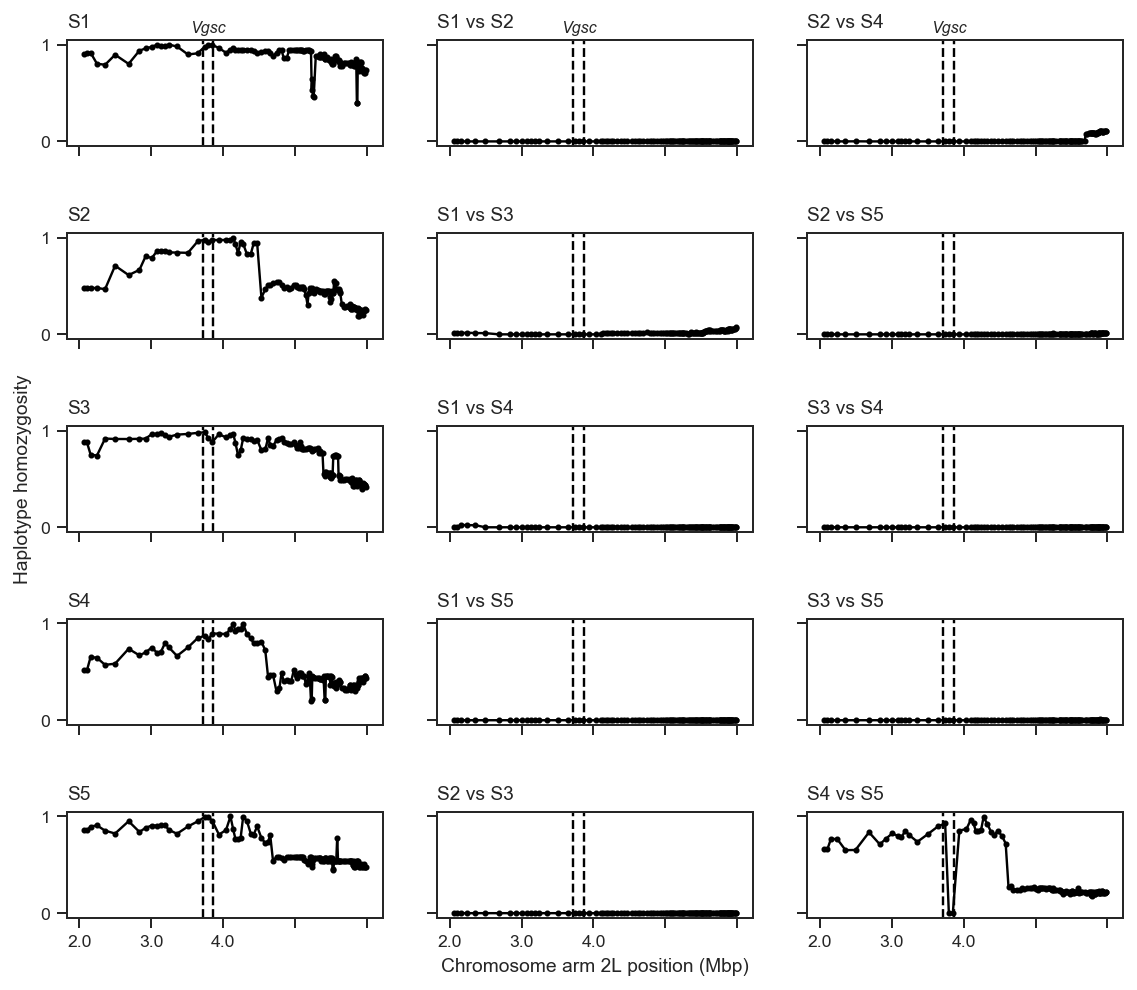

In [19]:
def fig_S_comparisons():

    window_size = 1000
    window_step = 500
    fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8, 7))
    for i in range(5):
        ax = axs[i, 0]
        g = 'S%s' % (i + 1)
        plot_hh_within(vgsc_haplogroups[g], window_size=window_size, window_step=window_step, ax=ax, label=g)
        ax.set_title(g, loc='left')
        ax.set_yticks([0, 1])
    #     ax.text(.98, .95, g, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

    combinations = list(itertools.combinations(range(1, 6), 2))
    axes_ixs = [(i, j) for j in range(1, 3) for i in range(5)]
    for (c1, c2), axes_ix in zip(combinations, axes_ixs):
        ax = axs[axes_ix]
        g1 = 'S%s' % c1
        g2 = 'S%s' % c2
        label = '%s vs %s' % (g1, g2)
        plot_hh_between(vgsc_haplogroups[g1], vgsc_haplogroups[g2], window_size=window_size, window_step=window_step, ax=ax, label=label)
        ax.set_title(label, loc='left')
        ax.set_yticks([0, 1])
    #     ax.text(.98, .95, label, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

    # annotations
    for i in range(3):
        axs[0, i].text((region_vgsc.start + region_vgsc.end)/2, 1.1, 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
    axs[2, 0].set_ylabel('Haplotype homozygosity')
    axs[-1, 1].set_xlabel('Chromosome arm 2L position (Mbp)')

    fig.tight_layout()
    fig.savefig('../artwork/mhh_S.pdf', bbox_inches='tight')
    
fig_S_comparisons()

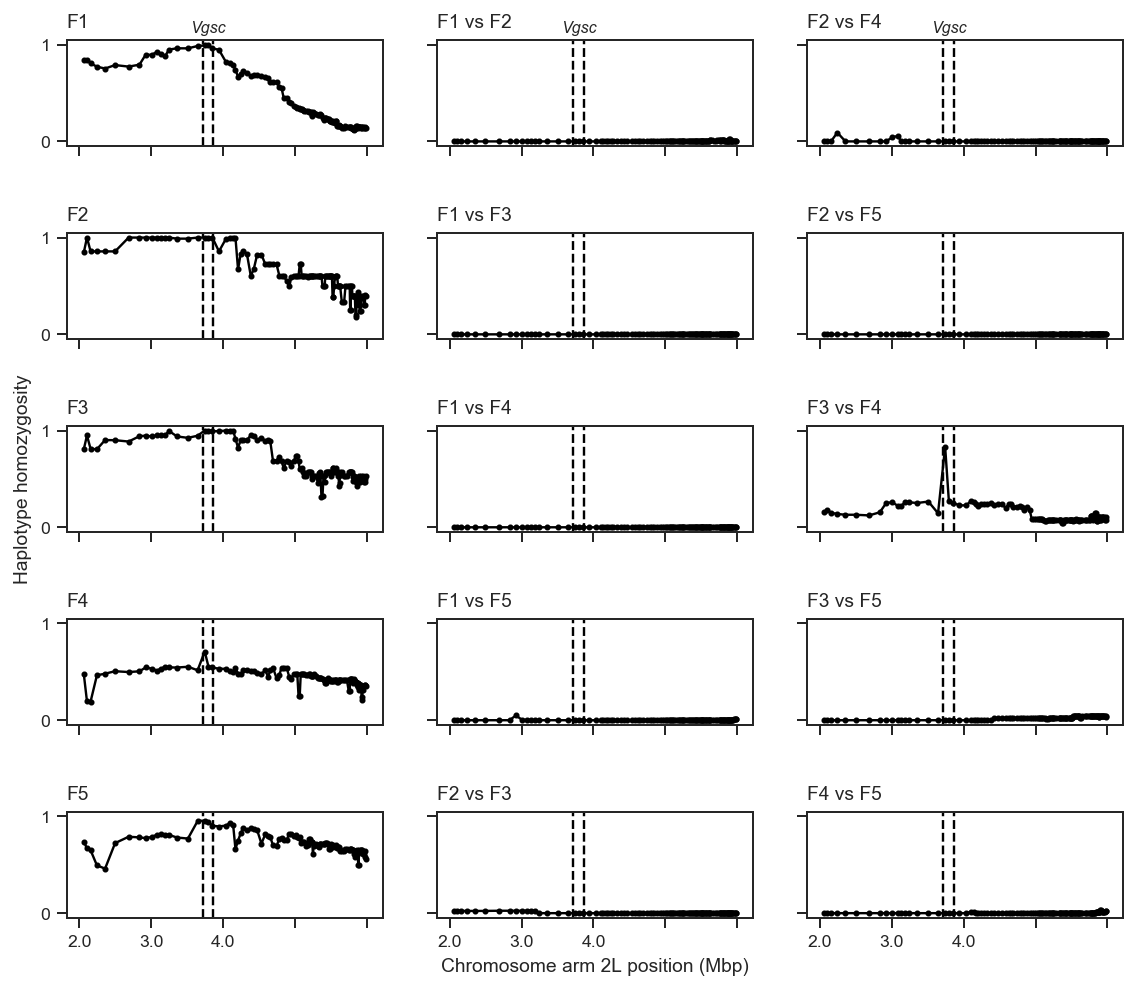

In [20]:
def fig_F_comparisons():
    window_size = 1000
    window_step = 500
    fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8, 7))
    for i in range(5):
        ax = axs[i, 0]
        g = 'F%s' % (i + 1)
        plot_hh_within(vgsc_haplogroups[g], window_size=window_size, window_step=window_step, ax=ax, label=g)
        ax.set_title(g, loc='left')
        ax.set_yticks([0, 1])
    #     ax.text(.98, .95, g, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

    combinations = list(itertools.combinations(range(1, 6), 2))
    axes_ixs = [(i, j) for j in range(1, 3) for i in range(5)]
    for (c1, c2), axes_ix in zip(combinations, axes_ixs):
        ax = axs[axes_ix]
        g1 = 'F%s' % c1
        g2 = 'F%s' % c2
        label = '%s vs %s' % (g1, g2)
        plot_hh_between(vgsc_haplogroups[g1], vgsc_haplogroups[g2], window_size=window_size, window_step=window_step, ax=ax, label=label)
        ax.set_title(label, loc='left')
        ax.set_yticks([0, 1])
    #     ax.text(.98, .95, label, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

    # annotations
    for i in range(3):
        axs[0, i].text((region_vgsc.start + region_vgsc.end)/2, 1.1, 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
    axs[2, 0].set_ylabel('Haplotype homozygosity')
    axs[-1, 1].set_xlabel('Chromosome arm 2L position (Mbp)')

    fig.tight_layout()
    fig.savefig('../artwork/mhh_F.pdf', bbox_inches='tight')

fig_F_comparisons()

## Fst analysis

In [21]:
region_vgsc

<SeqFeature 2L:2358158-2431617>

In [22]:
@functools.lru_cache(maxsize=None)
def scan_fst(hap_ixs1, hap_ixs2, startp=2000000, stopp=3000000):
    
    # setup data
    loc = pos_hh.locate_range(startp, stopp)
    p = pos_hh[loc]
    h1 = haps_hh[loc].take(hap_ixs1, axis=1)
    h2 = haps_hh[loc].take(hap_ixs2, axis=1)
    ac1 = h1.count_alleles(max_allele=3)
    ac2 = h2.count_alleles(max_allele=3)
    ac = ac1 + ac2
    loc_seg = ac.is_segregating()
    p, ac1, ac2 = p[loc_seg], ac1[loc_seg], ac2[loc_seg]
    num, den = allel.hudson_fst(ac1, ac2)
    fst = num / den
    return p, fst

In [23]:
def fig_fst_comparisons(prefix, startp, stopp, window_size=10, figsize=(8, 7), tick_snps=False):

    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=figsize)

    combinations = list(itertools.combinations(range(1, 6), 2))
    axes_ixs = [(i, j) for j in range(2) for i in range(5)]
    for (c1, c2), axes_ix in zip(combinations, axes_ixs):
        ax = axs[axes_ix]
        g1 = '%s%s' % (prefix, c1)
        g2 = '%s%s' % (prefix, c2)
        label = '%s vs %s' % (g1, g2)
        p, fst = scan_fst(vgsc_haplogroups[g1], vgsc_haplogroups[g2], startp=startp, stopp=stopp)
        ax.plot(p, fst, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
        wx = allel.moving_statistic(p, statistic=np.mean, size=window_size)
        wy = allel.moving_statistic(fst, statistic=np.mean, size=window_size)
        ax.plot(wx, wy, linestyle='-', color='k')
        ax.axvline(region_vgsc.start, linestyle='--', color='k')
        ax.axvline(region_vgsc.end, linestyle='--', color='k')
        ax.axvline(2422651, linestyle='-', color='r')
        ax.set_title(label, loc='left')
        ax.set_yticks([0, 1])
        if tick_snps:
            ax.set_xticks(p)
            ax.set_xticklabels(p, rotation=90)
        ax.set_xlim(startp, stopp)
    #     ax.text(.98, .95, label, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

    # annotations
#     for i in range(2):
#         axs[0, i].text((region_vgsc.start + region_vgsc.end)/2, 1.1, 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
    axs[2, 0].set_ylabel('$F_{ST}$')
    axs[-1, 1].set_xlabel('Chromosome arm 2L position (Mbp)')

    fig.tight_layout()
#     fig.savefig('../artwork/mhh_F.pdf', bbox_inches='tight')

In [24]:
region_vgsc

<SeqFeature 2L:2358158-2431617>

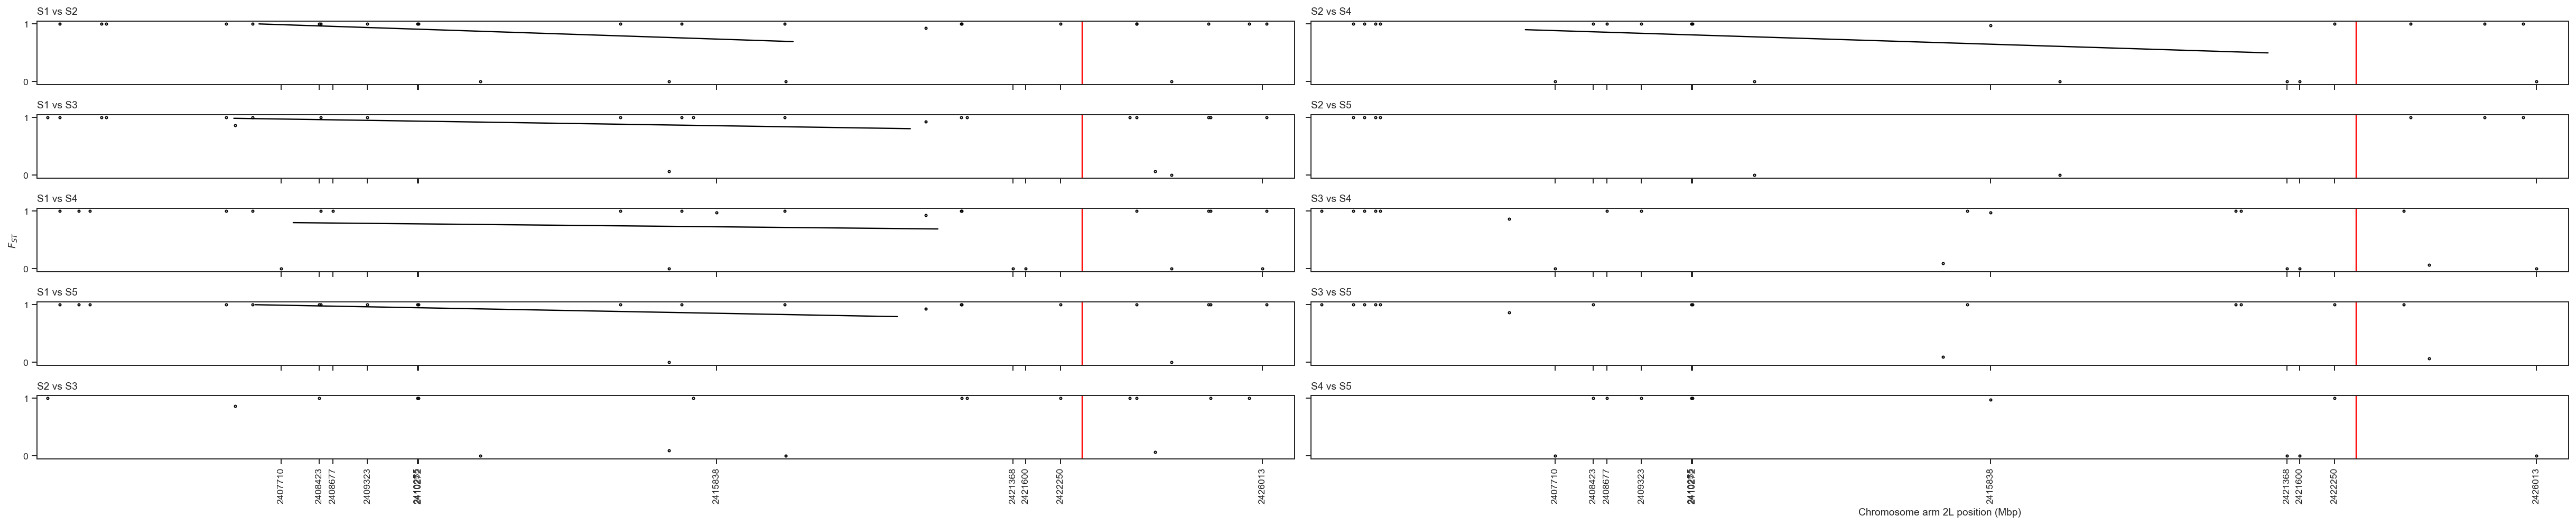

In [25]:
fig_fst_comparisons('S', startp=region_vgsc.start+45000, stopp=region_vgsc.end-5000, figsize=(34, 7), tick_snps=True)

In [26]:
# 8 SNPs differentiate S4, S5 in this region
2422250 - 2408423

13827

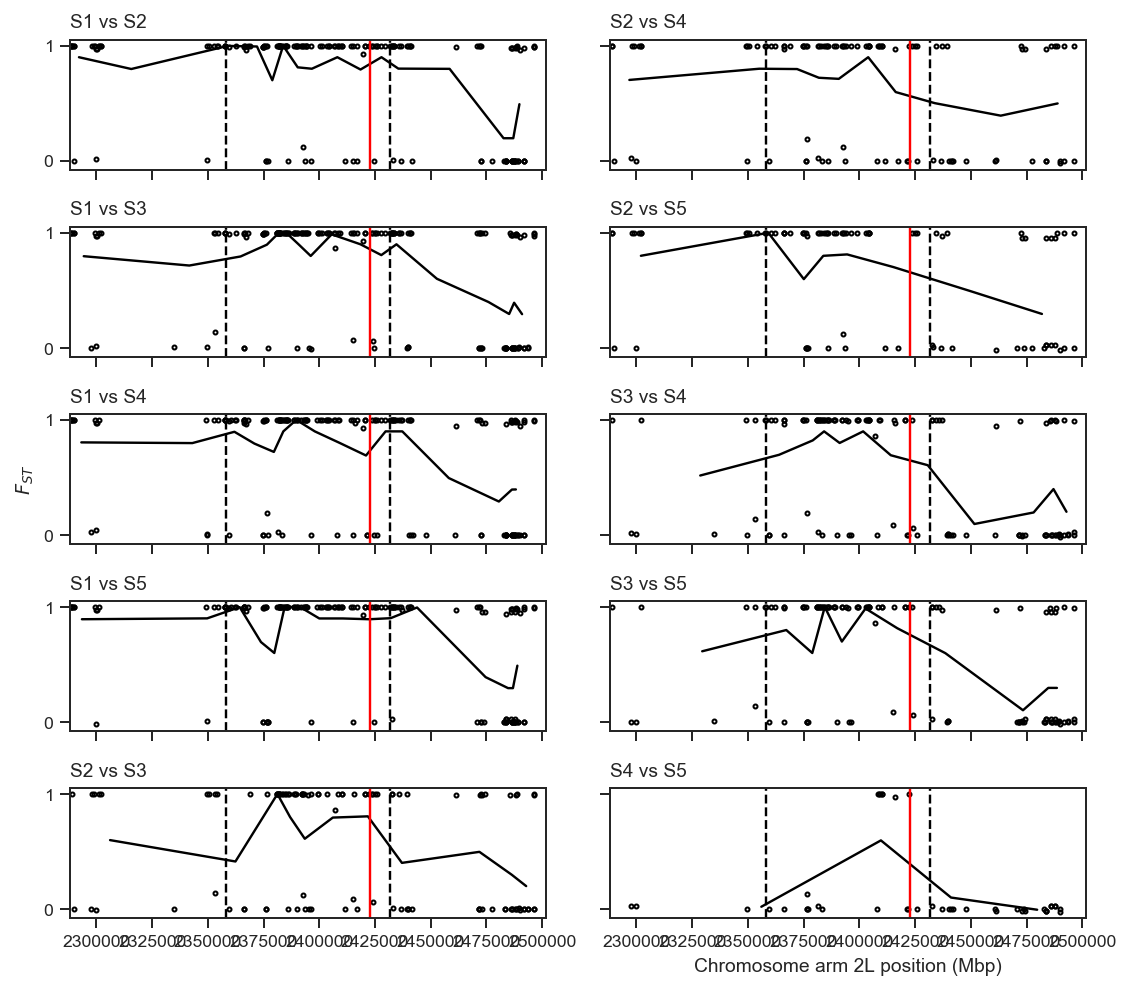

In [27]:
fig_fst_comparisons('S', startp=region_vgsc.start - 70000, stopp=region_vgsc.end + 70000)

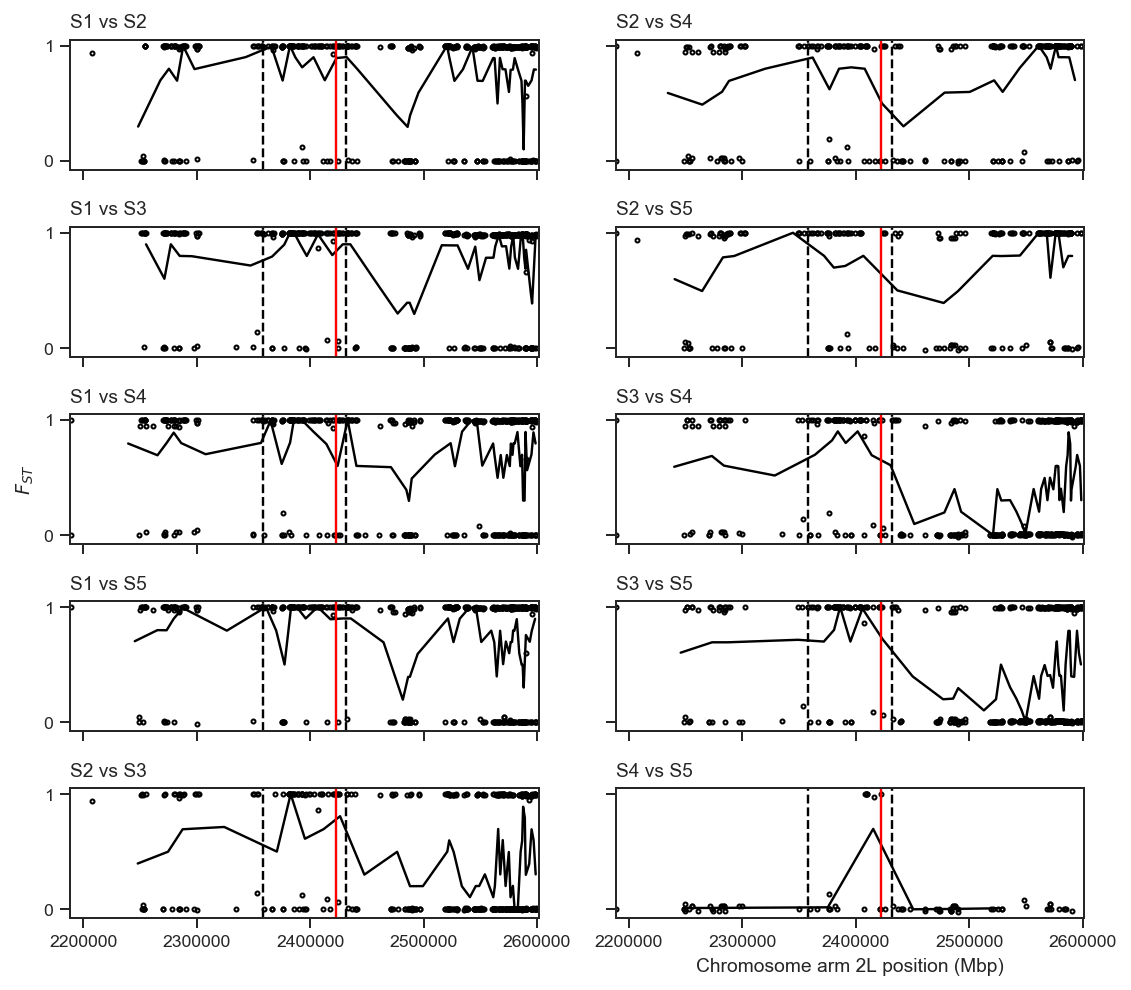

In [28]:
fig_fst_comparisons('S', startp=region_vgsc.start - 170000, stopp=region_vgsc.end + 170000)

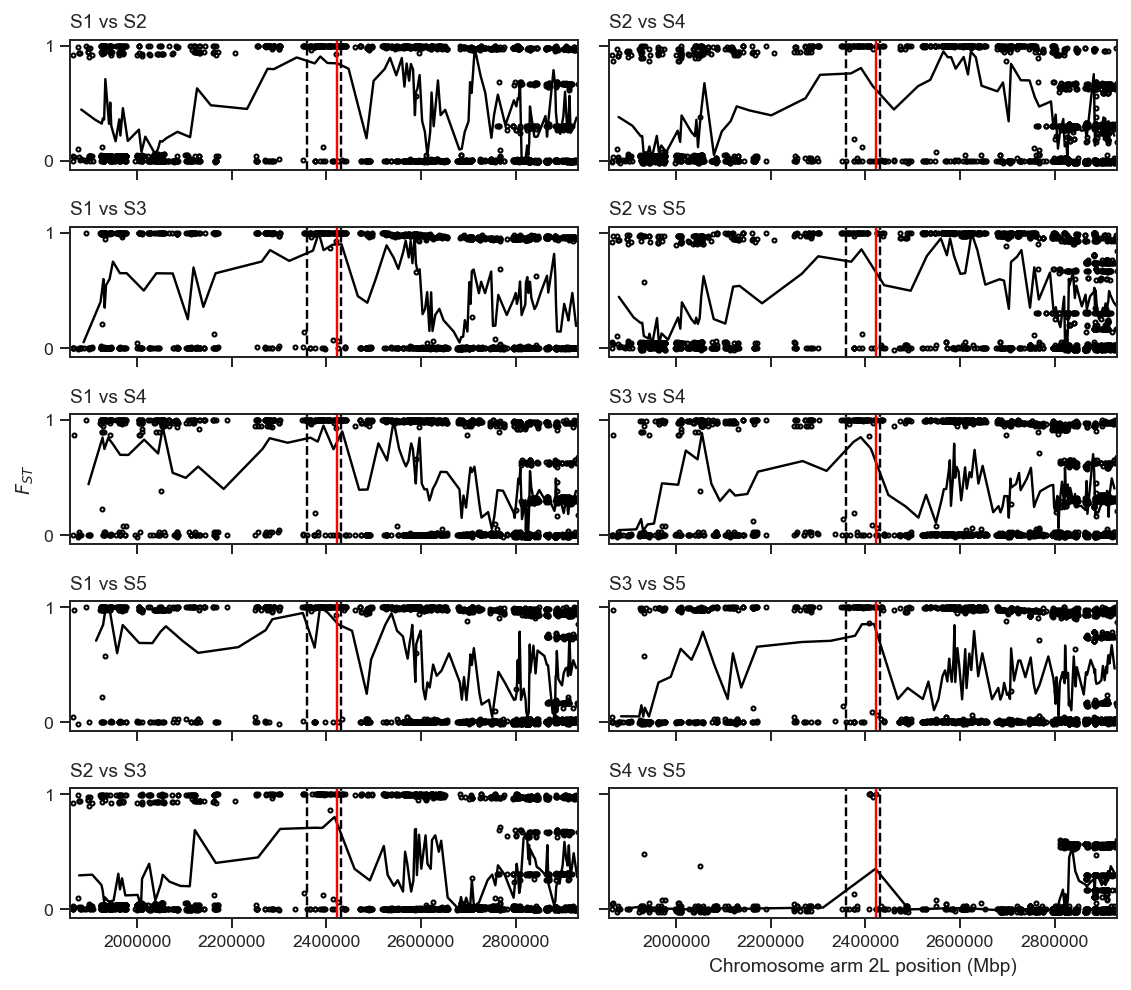

In [29]:
fig_fst_comparisons('S', startp=region_vgsc.start - 500000, stopp=region_vgsc.end + 500000, window_size=20)

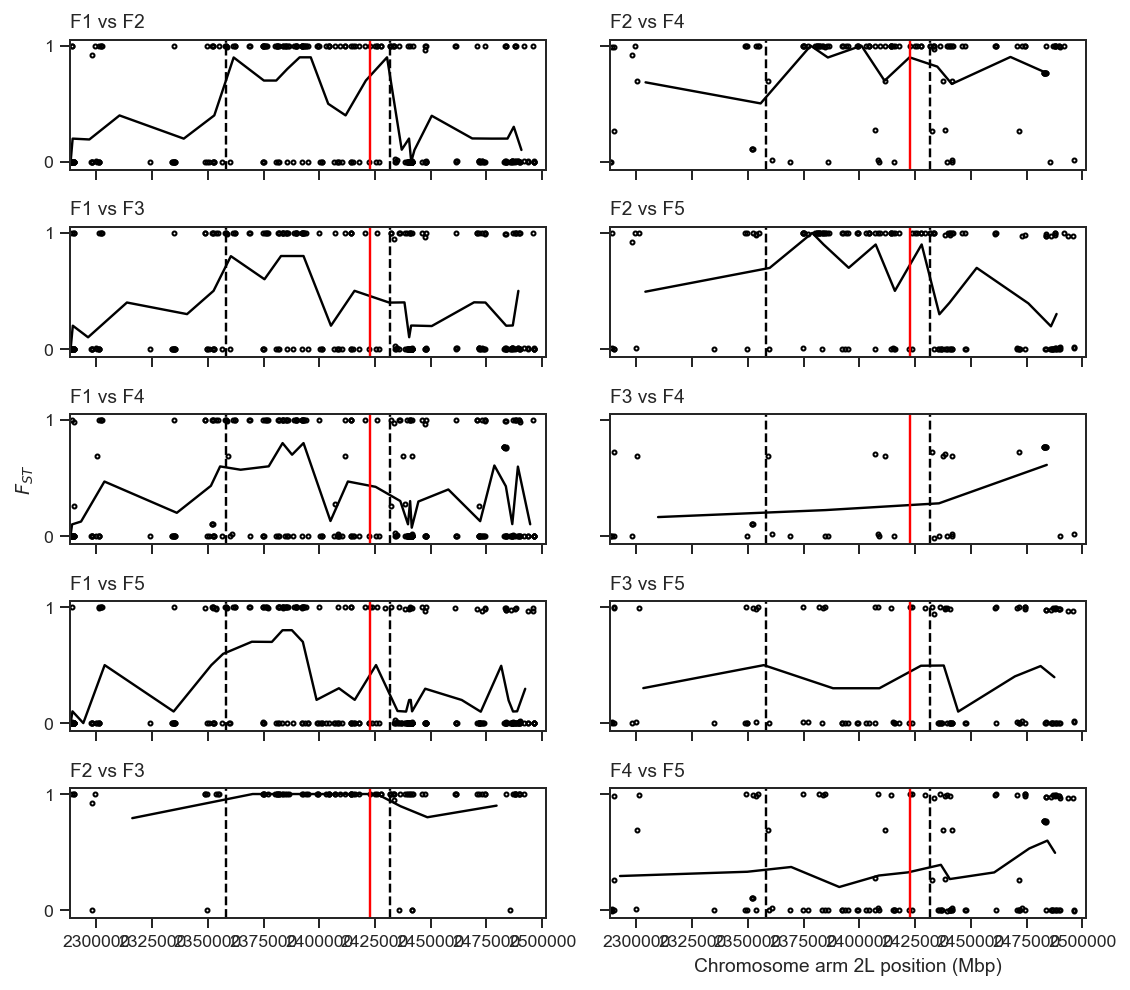

In [30]:
fig_fst_comparisons('F', startp=region_vgsc.start - 70000, stopp=region_vgsc.end + 70000)